- Put everything in functions and document each one
    - Clean from raw data to search query csv (search_query_creation) DONE, tested
    - Save search results using brightdata API (search_engine_results) DONE, need to test with modal
    - [optional] Save relevance score (llm_relevance_scoring) * not now
        - Use instructor/claude
    - Use unstructured to save content (partition_content) DONE, need to test with modal
    - [optional] Summarize lengthy content (llm_summarize_content) * not now
    - Simple truncate lengthy content maybe using fuzzy name matching algorithm (truncate_content) DONE, need to test
    - LLM final score/summarize step (llm_score_summarize)
        - Use instructor/Claude

In [29]:
def search_query_creation(raw_df, sample_size=0, capacity=1, tech_type=["PV", "WT"]):
    """
    This function takes in a dataframe containing raw EIA-860 data on energy projects and returns a df with cleaned, selected data and a search query for each project, with a random selection of renewable energy projects according to the sample size and technology type provided. 
    If sample_size = 0 (default), the function returns all projects. If tech_type is left as default, the function returns only PV and WT (solar and wind).
    """
    import pandas as pd 
    import numpy as np
    raw_df = raw_df.dropna(subset=['Plant Code'])
    df = pd.DataFrame()
    df['plant_name'] = raw_df['Plant Name']
    # get df['plant_code'] from gen_2022['Plant Code'] as dtype int
    df['plant_code'] = raw_df['Plant Code'].astype(int)
    df = df.dropna(subset=['plant_code'])
    df['county'] = raw_df['County']
    df['state'] = raw_df['State']
    df['capacity'] = raw_df['Nameplate Capacity (MW)']
    df['capacity'] = df['capacity'].str.replace(',', '').replace(' ', np.nan).astype(float)
    # only include capacities greater than capacity specified
    df = df[df['capacity'] > capacity]
    df['tech_type'] = raw_df['Prime Mover']
    df['op_year'] = raw_df['Operating Year']
    df = df.drop_duplicates(subset=['plant_code'])
    df = df[df['tech_type'].isin(tech_type)]
    df = df.reset_index(drop=True)
    # Get random sample of 25 rows with even distribution of capacity
    if sample_size != 0:
        df = df.sample(n=sample_size, weights='capacity', random_state=1)
    # reset index
    df = df.reset_index(drop=True)
    # create search query
    df['search_query'] = df.apply(lambda x: search_query(x['plant_name'], x['county'], x['state'], x['tech_type']), axis=1)
    df['result'] = ''
    df['num_result'] = ''
    df['full_content']=''
    return df


In [30]:
import pandas as pd
opgen_2022 = pd.read_csv('opgen_2022.csv', header=2)


/var/folders/m5/0x0gwbxx1kz02qrmghysp2mw0000gn/T/ipykernel_95701/4225607511.py:2: DtypeWarning: Columns (0,15,17,18,25,26,35,36,37,38,40,41,42,51,52,53,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  opgen_2022 = pd.read_csv('opgen_2022.csv', header=2)


In [31]:
ready_to_search = search_query_creation(opgen_2022, sample_size=0, capacity=1, tech_type=["PV", "WT"])
ready_to_search.head()

plant_name  plant_code        county state  capacity tech_type  \
0             Lamar Plant         508       Prowers    CO       4.5        WT   
1                Big Bend         645  Hillsborough    FL      19.8        PV   
2            Medicine Bow         692        Carbon    WY       4.9        WT   
3                 Willmar        2022     Kandiyohi    MN       2.0        WT   
4  Searsburg Wind Turbine        7381    Bennington    VT       6.0        WT   

  op_year                                       search_query result  \
0    2004  Lamar Plant Wind Prowers County Colorado contr...          
1    2017  Big Bend Solar Hillsborough County Florida con...          
2    2000  Medicine Bow Wind Carbon County Wyoming contro...          
3    2009  Willmar Wind Kandiyohi County Minnesota contro...          
4    1997  Searsburg Wind Turbine Bennington County Vermo...          

  num_result full_content  
0                          
1                          
2                          
3                          
4

5095
tech_type
PV    3841
WT    1254
Name: plant_code, dtype: int64


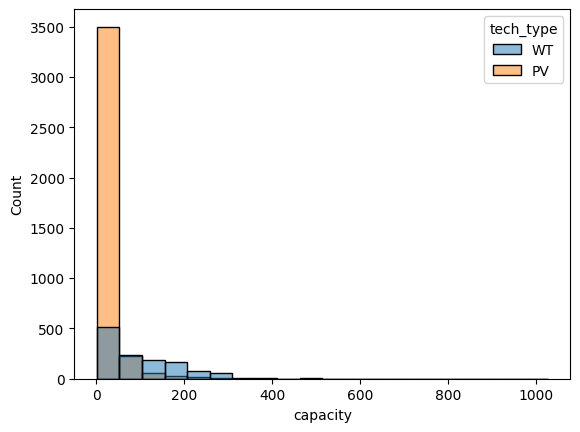

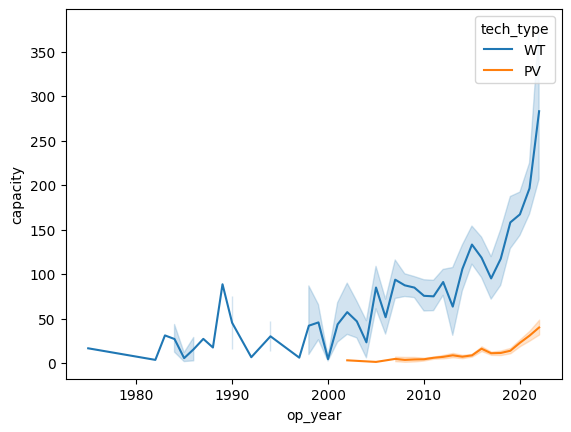

In [35]:
# print number of unique plant codes in ready_to_search
print(len(ready_to_search['plant_code'].unique()))
# print nubmber of unique plant codes in ready to search by tech type
print(ready_to_search.groupby('tech_type')['plant_code'].nunique())
# plot distribution of capacity by tech type
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(data=ready_to_search, x='capacity', hue='tech_type', bins=20)
plt.show()

# plot sum of capacity over op_year
sns.lineplot(data=ready_to_search, x='op_year', y='capacity', hue='tech_type')
plt.show()


In [36]:
import pandas as pd

# Load the plant_2022.csv file
plant_2022 = pd.read_csv('plant_2022.csv', header=2)

# Ensure the 'Plant Code' in plant_2022 and 'plant_code' in ready_to_search are of the same data type
plant_2022['Plant Code'] = plant_2022['Plant Code'].astype(int)
ready_to_search['plant_code'] = ready_to_search['plant_code'].astype(int)

# Merge the latitude and longitude from plant_2022 to ready_to_search based on matching plant codes
ready_to_search = ready_to_search.merge(plant_2022[['Plant Code', 'Latitude', 'Longitude']], how='left', left_on='plant_code', right_on='Plant Code')

# Rename the merged columns for consistency
ready_to_search.rename(columns={'Latitude': 'lat', 'Longitude': 'long'}, inplace=True)

# Drop the extra 'Plant Code' column after merge
ready_to_search.drop(columns=['Plant Code'], inplace=True)

ready_to_search.head()


plant_name  plant_code        county state  capacity tech_type  \
0             Lamar Plant         508       Prowers    CO       4.5        WT   
1                Big Bend         645  Hillsborough    FL      19.8        PV   
2            Medicine Bow         692        Carbon    WY       4.9        WT   
3                 Willmar        2022     Kandiyohi    MN       2.0        WT   
4  Searsburg Wind Turbine        7381    Bennington    VT       6.0        WT   

  op_year                                       search_query result  \
0    2004  Lamar Plant Wind Prowers County Colorado contr...          
1    2017  Big Bend Solar Hillsborough County Florida con...          
2    2000  Medicine Bow Wind Carbon County Wyoming contro...          
3    2009  Willmar Wind Kandiyohi County Minnesota contro...          
4    1997  Searsburg Wind Turbine Bennington County Vermo...          

  num_result full_content        lat         long  
0                          38.033327  -102.537915  
1                          27.794400   -82.403600  
2                          41.835278  -106.242778  
3                          45.121705   -95.053236  
4                          42.862500   -72.962800

In [37]:
# save ready_to_search to csv
ready_to_search.to_csv('ready_to_search.csv', index=False)

In [5]:
import pandas as pd
# ready_to_search = pd.read_csv('ready_to_search.csv')
ready_to_search['plant_info'] = ready_to_search.apply(lambda x: search_query(x['plant_name'], x['county'], x['state'], x['tech_type'], keywords=None), axis=1)
ready_to_search.to_csv('ready_to_search.csv', index=False)

In [2]:
# using "lat" and "long" columns to create a map of the renewable energy projects, with size of the marker corresponding to the capacity of the projectg
import folium
from folium.plugins import MarkerCluster
from folium import IFrame

# Create a map centered at the mean latitude and longitude of the projects
map_projects = folium.Map(location=[ready_to_search['lat'].mean(), ready_to_search['long'].mean()], zoom_start=4)

# Create a MarkerCluster object
marker_cluster = MarkerCluster().add_to(map_projects)

# Add markers to the map for each project
for i, row in ready_to_search.iterrows():
    # Create a string with the project details
    popup_text = f"<b>{row['plant_name']}</b><br>Capacity: {row['capacity']} MW<br>Technology: {row['tech_type']}<br>Location: {row['county']}, {row['state']}"
    # Create a popup with the project details
    popup = folium.Popup(popup_text, max_width=300, min_width=300)
    # Create a marker with the popup
    marker = folium.Marker(location=[row['lat'], row['long']], popup=popup)
    # Add the marker to the MarkerCluster
    marker.add_to(marker_cluster)

# Display the map
map_projects


In [14]:
import pandas as pd
df = pd.read_csv('opgen_2022.csv', header =2)
df_filtered = search_query_creation(df, 0, ["PV", "WT"])

/var/folders/m5/0x0gwbxx1kz02qrmghysp2mw0000gn/T/ipykernel_95701/1959683069.py:2: DtypeWarning: Columns (0,15,17,18,25,26,35,36,37,38,40,41,42,51,52,53,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('opgen_2022.csv', header =2)


In [15]:
# print length of unique plant_code in df_filtered
print(len(df_filtered['plant_code'].unique()))

6125


In [16]:
# drop duplicate plant_code
df_filtered = df_filtered.drop_duplicates(subset=['plant_code'])
# print length of unique plant_code in df_filtered
print(len(df_filtered['plant_code'].unique()))

6125


In [46]:
import pandas as pd
opgen_2022 = pd.read_csv('opgen_2022.csv', header=2)
test_25 = search_query_creation(raw_df=opgen_2022, sample_size=25)
test_25.head()

/var/folders/m5/0x0gwbxx1kz02qrmghysp2mw0000gn/T/ipykernel_53377/603514363.py:2: DtypeWarning: Columns (0,15,17,18,25,26,35,36,37,38,40,41,42,51,52,53,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  opgen_2022 = pd.read_csv('opgen_2022.csv', header=2)


plant_name  plant_code     county state  capacity tech_type  \
0            Old Mill Solar       59374    Klamath    OR       5.0        PV   
1  Debary Solar Power Plant       62542    Volusia    FL      74.5        PV   
2              Medicine Bow         692     Carbon    WY       4.9        WT   
3              El Cabo Wind       58098   Torrance    NM     298.0        WT   
4     Oakfield Wind Project       57002  Aroostook    ME     148.0        WT   

  op_year                                       search_query  
0    2015  Old Mill Solar Klamath County Oregon controver...  
1    2020  Debary Solar Power Plant Volusia County Florid...  
2    2000  Medicine Bow Wind Carbon County Wyoming contro...  
3    2017  El Cabo Wind Torrance County New Mexico contro...  
4    2015  Oakfield Wind Project Aroostook County Maine c...

In [1]:
def search_query(plant_name, county, state, prime_mover, keywords=["controversy", "opposition", "lawsuit", "conflict", "hearing"]):
    """ This function takes in the Plant Name, County, State, and Prime Mover and returns a web engine search query string with the Plant Name County State and "(controversy OR opposition OR lawsuit OR conflict OR hearing)"""
    # Make sure plant_name, county, state, and prime_mover are all strings
    import json
    plant_name = str(plant_name)
    county = str(county)
    state = str(state)
    prime_mover = str(prime_mover)
    # if the Prime Mover is "PV" and the Plant Name DOES NOT contain "solar" then add "solar" to the search query
    if prime_mover == "PV" and "solar" not in plant_name.lower():
        plant_name += " Solar"
    # If the Prime Mover is "WT" and the Plant Name DOES NOT contain "wind" then add "wind" to the search query
    if prime_mover == "WT" and "wind" not in plant_name.lower():
        plant_name += " Wind"
    #remove "LLC" from the plant name if it exists
    plant_name = plant_name.replace(" LLC", "")
    # Use abbrev_to_us_state json file to convert state abbreviation to full state name
    if len(state) == 2:
        with open('abbrev_to_us_state.json') as f:
            abbrev_to_us_state = json.load(f)
        state = state.upper()
        state = abbrev_to_us_state[state]
    # create the search query
    if keywords == None:
        keywords_str = ""
    else:
        keywords_str = " OR ".join(keywords) + " "
    search_query = f"{plant_name} {county} County {state} {keywords_str}"
    search_query = search_query.replace('"', "")
    return search_query

In [17]:
print(search_query("Cedar Creek Wind Farm LLC", "Weld", "CO", "WT"))

Cedar Creek Wind Farm Weld County Colorado controversy OR opposition OR lawsuit OR conflict OR hearing 


In [17]:
import pandas as pd
sample_25=pd.read_csv('sample_25.csv')
sample_25.head()

plant_name  plant_code     county state  capacity tech_type  \
0            Old Mill Solar       59374    Klamath    OR       5.0        PV   
1  Debary Solar Power Plant       62542    Volusia    FL      74.5        PV   
2              Medicine Bow         692     Carbon    WY       4.9        WT   
3              El Cabo Wind       58098   Torrance    NM     298.0        WT   
4     Oakfield Wind Project       57002  Aroostook    ME     148.0        WT   

   op_year                                       search_query  \
0     2015  Old Mill Solar Klamath County Oregon (controve...   
1     2020  Debary Solar Power Plant Volusia County Florid...   
2     2000  Medicine Bow Wind Carbon County Wyoming (contr...   
3     2017  El Cabo Wind Torrance County New Mexico (contr...   
4     2015  Oakfield Wind Project Aroostook County Maine (...   

                                              result  num_results  \
0  {"general": {"search_engine": "google", "langu...           10   
1  {"general": {"search_engine": "google", "resul...            9   
2  {"general": {"search_engine": "google", "resul...           10   
3  {"general": {"search_engine": "google", "resul...           10   
4  {"general": {"search_engine": "google", "resul...           10   

                                        full_content  
0  \nAn old timber mill takes on a new role gener...  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4                                                NaN

In [25]:
import pandas as pd
import json
score_25 = pd.read_csv('sample_25.csv')
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

for index, plant in score_25.iterrows():
    organic_results = json.loads(plant['result']).get('organic', [])
    print(organic_results)
    for index, result in organic_results:
        print(result['title'])
        result['article_letter'] = alphabet[index]
        
    break

[{'link': 'https://www.nexteraenergyresources.com/pdf/Old-Mill-case-study.pdf', 'display_link': 'https://www.nexteraenergyresources.com › pdf', 'title': 'An old timber mill takes on a new role generating clean ...', 'description': '» asserted its position as a solar energy leader in the state of Oregon. The rural community of Bly in Klamath County, Oregon, has a rich history of logging and ...', 'extensions': [{'type': 'text', 'text': '1 page', 'rank': 1}, {'type': 'missing', 'text': '(controversy', 'rank': 2}, {'type': 'must_include', 'text': '(controversy', 'link': 'https://www.google.com/search?sca_esv=58652087346d5a22&gl=us&hl=en&q=Old+Mill+Solar+Klamath+County+Oregon+%22(controversy%22+OR+opposition+OR+lawsuit+OR+conflict+OR+hearing)&sa=X&ved=2ahUKEwiq4riwhYOFAxWvF1kFHXhnA8cQ5t4CegQIJBAB', 'rank': 3}], 'rank': 1, 'global_rank': 1, 'content': 'Could not access content'}, {'link': 'https://columbiainsight.org/rural-solar-project-faces-local-opposition-wildlife-concerns/', 'display_l

In [48]:
def search_engine_results(df):
    """
    This function takes in a dataframe with a column 'search_query' and returns a dataframe with the search query and the search engine results for each search query.
    """
    from tqdm import tqdm
    import urllib.request
    import urllib.parse
    import requests
    import os
    import json
    import pandas as pd
    df['result'] = ''
    for index, row in tqdm(df.iterrows()):
        try: 
            if row['search_query'] != 'initial' or pd.isnull(row['result']):
                search = str(row['search_query'])

                opener = urllib.request.build_opener(
                    urllib.request.ProxyHandler(
                        {'http': os.environ['BRIGHTDATA_SERP_KEY'],
                        'https': os.environ['BRIGHTDATA_SERP_KEY']}))
                search_query = urllib.parse.quote_plus(search)

                results = json.loads(opener.open(f'http://www.google.com/search?q={search_query}&brd_json=1').read())
                df.at[index, 'result'] = json.dumps(results)
            else: pass
        except:
            df.at[index, 'result'] = 'No results'
    return df

In [6]:
def partition_content(df):
    from tqdm import tqdm
    import pandas as pd
    import json
    import requests
    from unstructured.partition.auto import partition
    from unstructured.partition.html import partition_html
    headers = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Methods': 'GET',
    'Access-Control-Allow-Headers': 'Content-Type',
    'Access-Control-Max-Age': '3600',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }
    def truncate_content(content, max_chars=10000):
        """
        This function takes in a string and truncates it to the first 10000 characters.
        """
        if len(content) > max_chars:
            trunc_content = content[:max_chars] + "... Remaining content truncated. Full length: " + str(len(content)) + " characters."
            return trunc_content
        return content
    df['full_content'] = ''
    for index, plant in tqdm(df.iterrows()):
        if plant['num_results'] < 1 or plant['full_content'] != '':
            continue
        full_text = ''
        current_results = json.loads(plant['result'])
        organic_results = current_results.get('organic', [])

        for search_result in tqdm(organic_results):
            try:
                print(search_result['link'])
                r = requests.get(search_result['link'], headers, timeout=30)
                content_type = r.headers.get('content-type')
                if 'text/html' in content_type:
                    elements = partition_html(url=search_result['link'], headers=headers, html_assemble_articles=True, timeout=30)
                else:
                    elements = partition(url=search_result['link'], headers=headers, timeout=30)
                text = "\n".join(element.text for element in elements)
                # add text to new 'content' in ['organic'] such that it updates in sample_25
                search_result['content'] = truncate_content(text)
            except requests.exceptions.Timeout:
                print('Timed out:', search_result['link'])
                search_result['content'] = 'Timed out'
                text = 'Timed out'
                breakpoint()
            except:
                print('Error with url:', search_result['link'])
                text = 'Could not access content'
                search_result['content'] = truncate_content(text)
            if 'title' not in search_result:
                search_result['title'] = ''
            if 'description' not in search_result:
                search_result['description'] = ''
            full_text += '\n' + search_result['title'] + '\n' + search_result['description'] + '\n' + search_result['content']
        # Serialize the modified search results back to JSON and update the 'result' column
        # Update the 'organic' list in the current_results with the modified search results
            current_results['organic'] = organic_results
            # Serialize the updated current_results back to JSON and save it in the 'result' column
            df.at[index, 'result'] = json.dumps(current_results)
    # Update the 'full_content' column for the current row with the concatenated text
        df.at[index, 'full_content'] = full_text    
    # print(full_text)
    # stop after one plant
        break


In [1]:
import pandas as pd
sample_25 = pd.read_csv('sample_25.csv')

In [8]:
from pydantic import BaseModel, Field
from typing import List
from anthropic import Anthropic
import instructor
import json

class ProjectPerceptions(BaseModel):
    mention_support: int = Field(..., description="1 if any mention of support (e.g., an individual or organization mentioned in support of the project), 0 if not")
    mention_opp: int = Field(..., description="1 if any mention of opposition (e.g., an individual or organization mentioned in opposition of the project), 0 if not")
    physical_opp: int = Field(..., description="1 if evidence of physical opposition involving at least one person (e.g., protests, marches, picketing, mass presence at governmental meetings), 0 if not")
    policy_opp: int = Field(..., description="1 if evidence of the use or attempted use of legislation or permitting to block projects, 0 if not")
    legal_opp: int = Field(..., description="1 if evidence of legal challenges and the use of courts to block projects, 0 if not")
    opinion_opp: int = Field(..., description="1 if any opinion-editorials or other media explicitly opposing a project exist, 0 if not")
    # Add binaries for mentions of underlying sources of opposition (e.g., environmental, economic, social, etc.)
    narrative: str = Field(..., description="A one-paragraph narrative summary of the public perceptions of the specified renewable energy project, including the project name, location, and developer, when it was proposed, the public response, and details on any evidence of opposition or support.")

class ProjectPerceptionsDetailed(BaseModel):
    mention_support: int = Field(..., description="1 if any mention of support (e.g., an individual or organization mentioned in support of the project), 0 if not")
    mention_opp: int = Field(..., description="1 if any mention of opposition (e.g., an individual or organization mentioned in opposition of the project), 0 if not")
    # binaries for expressions of opposition
    physical_opp: int = Field(..., description="1 if evidence of physical opposition involving at least one person (e.g., protests, marches, picketing, mass presence at governmental meetings), 0 if not")
    policy_opp: int = Field(..., description="1 if evidence of the use or attempted use of legislation (like ordinances or moratoria) or permitting to block projects, 0 if not")
    legal_opp: int = Field(..., description="1 if evidence of legal challenges and the use of courts to block projects, 0 if not")
    opinion_opp: int = Field(..., description="1 if any opinion-editorials or other media explicitly opposing a project exist, 0 if not")
    # binaries for underlying sources of opposition (e.g., environmental, economic, social, etc.)
    environmental_opp: int = Field(..., description="1 if evidence of environmental concerns, like water, soil, wildlife, and ecological impacts, 0 if not")
    participation_opp: int = Field(..., description="1 if evidence of opposition stemming from a perceived or real lack of participation of fairness in the project, 0 if not")
    tribal_opp: int = Field(..., description="1 if evidence of Tribal opposition, 0 if not")
    health_opp: int = Field(..., description="1 if evidence of opposition from real or perceived health and safety risks from the project, 0 if not")
    intergov_opp: int = Field(..., description="1 if any evidence of disagreement between local, regional, and federal government about the project, 0 if not")
    property_opp: int = Field(..., description="1 if evidence of opposition from real or perceived property value impacts, 0 if not")
    # binaries for additional compensation (CBAs) and delays
    compensation: int = Field(..., description="1 if evidence of support or opposition from real or perceived lack of additional non-required compensation or benefits from the project, 0 if not")
    delay: int = Field(..., description="1 if evidence of a substantial delay (months or years) in project development because of opposition, 0 if not")
    co_land_use: int = Field(..., description="1 if evidence of project co-existing with other land uses, such as agriculture, recreation, and grazing, 0 if not")
    narrative: str = Field(..., description="A one-paragraph narrative summary of the public perceptions of the specified renewable energy project, including the project name, location, and developer, when it was proposed, the public response, and details on any evidence of opposition or support.")


class ProjectSummary(BaseModel):
    scores: List[ProjectPerceptionsDetailed]

client = instructor.from_anthropic(Anthropic())



for index in range(len(sample_25)):
    project_perceptions = client.messages.create(
        model="claude-3-opus-20240229",
        response_model=ProjectSummary,
        max_tokens=4096,
        messages=[
            {"role": "system", "content": f'Our aim is to understand the public opinion and perceptions of a particular renewable energy project based solely on online media evidence from a search engine query on the project. Based on the full text content of all search results, we would like to answer several binary questions about whether or not there is evidence of opposition or support for the project. Use only the text content provided to answer these questions with a “1” if evidence is found and “0” if not, and finally to create a one-paragraph summary of public perceptions of the project.'},
            {"role": "user", "content": f"Here is the name and location of the project in question ({sample_25.iloc[index]['plant_name']} {sample_25.iloc[index]['county']} {sample_25.iloc[index]['state']}) from which the following search result content is generated: {sample_25.iloc[index]['full_content']}"}
        ],
    )
    assert isinstance(project_perceptions, ProjectSummary)
    sample_25.at[index, 'plant_summary'] = json.dumps(project_perceptions.model_dump_json(), indent=2).split('\n')
    break


In [5]:
for line in json.dumps(project_perceptions.model_dump_json(), indent=2).split('\n'):
    print(line)

{
  "scores": [
    {
      "mention_support": 0,
      "mention_opp": 1,
      "physical_opp": 0,
      "policy_opp": 0,
      "legal_opp": 0,
      "opinion_opp": 1,
      "narrative": "The Old Mill Solar project is a proposed 5 MW, 40 acre solar energy facility in Klamath County, Oregon. An article from November 2020 indicates the project faces local opposition and wildlife concerns from some of its potential neighbors in the rural Langell Valley area. Residents raised concerns about the facility's water usage, potential to decrease property values, and impacts to wetland areas and wildlife like sandhill cranes, western pond turtles, and migrating deer. The search results do not provide clear evidence of organized physical opposition activities, legal challenges, or use of policy/permitting processes to block the project. However, the article expresses the local resident concerns and general opposition to the facility's siting and impacts."
    }
  ]
}


In [9]:
for line in json.dumps(project_perceptions.dict(), indent=2).split('\n'):
    print(line)

{
  "scores": [
    {
      "mention_support": 0,
      "mention_opp": 1,
      "physical_opp": 0,
      "policy_opp": 1,
      "legal_opp": 0,
      "opinion_opp": 1,
      "environmental_opp": 1,
      "participation_opp": 0,
      "tribal_opp": 0,
      "health_opp": 0,
      "intergov_opp": 0,
      "narrative": "The proposed Klamath County, Oregon solar ordinance generated mixed public opinions during its development from 2019-2022. The ordinance aims to allow commercial solar energy facilities while protecting the county's valuable agricultural land, water rights, and crucial deer winter habitat areas. Key provisions include prohibiting solar on high-value farmland and the most important winter deer ranges. Application requirements and review standards address issues like setbacks, weed control, decommissioning plans and securities. Public comments were split between solar industry advocates who felt the restrictions went too far in limiting development opportunities, and others 

### Next Steps
- Add property value, CBA, co-land uses, evidence of a delay (done)
- Add relevance score 
- Use cheaper model
- Clean + chunk using unstructured 
- pass chunks and embeddings with vectorstore, and query using project name
- implement caching of all intermediate results in local files